# Use get_spiral_start function to find trial start
## Have checked manually by comparing to stim artifact on:

* J064 run 13
* J064 run 14
* J063 run 8
* J065 run 14

### Stim starts max 2 frames (rare) before detected spiral start and max 1 frame after. Most detected are either frame with onset of artifact or 1 frame after that 



In [20]:
%run ../setup_notebook.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pickle
from subsets_analysis import Subsets
import utils.utils_funcs as uf
import utils.run_functions as rf
import math

%matplotlib inline

In [3]:
mice_dicts = [
    
{'mouse_id': 'J048', 'run_numbers': [27,28,29,30,32], 'runs': []},
{'mouse_id': 'RL048', 'run_numbers': [23, 24, 25, 28, 29], 'runs': []},
{'mouse_id': 'J063', 'run_numbers': [8,9,10,11,12,13,14], 'runs': []},
{'mouse_id': 'J064', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
{'mouse_id': 'J065', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
    
]

mice_dicts = [
            {'mouse_id': 'J063', 'run_numbers': [8], 'runs': []} ] 

In [4]:
for mouse_dict in mice_dicts:
    for run_number in mouse_dict['run_numbers']:
        
        pkl_path = os.path.join(path_to_vape, 'run_pkls', mouse_dict['mouse_id'], 
                                'run{}.pkl'.format(run_number))

        with open(pkl_path, 'rb') as f:
            run = pickle.load(f)
            
        mouse_dict['runs'].append(run)
                

In [5]:
run = mice_dicts[0]['runs'][0]
run.x_galvo_uncaging[0:int(0.145088e8)] = -1

In [6]:
run.__dict__.keys()

dict_keys(['mouse_id', 'df', 'rows_2p', 'rows_1p', 'dates_2p', 'paqs', 'naparm_folders', 'blimp_folders', 'pycontrol_folders', 'prereward_folders', 'tseries_folders', 'plane_numbers', 'run_pycontrol_txt', 'num_planes', 'blimp_path', 'naparm_path', 'pycontrol_path', 'paq_path', 'prereward_path', 'tseries_paths', 'align_barcode', 'trial_info', 'session', 'print_lines', 'trial_time', 'outcome', 'slm_barcode', 'slm_trial_number', 'nogo_barcode', 'nogo_trial_number', 'alltrials_barcodes', 'rsync', 'trial_start', 'paq_rsync', 'frame_clock', 'x_galvo_uncaging', 'slm2packio', 'paq_rate', 'aligner', 'paq_correct', 'pre_rsync', 'pre_licks', 'pre_reward', 'prereward_aligner', 'both_aligner', 'num_frames', 's2p_path', 'spiral_start'])

In [7]:
def my_floor(a, precision=0):
    # Floors to a specified number of dps
    return np.round(a - 0.5 * 10**(-precision), precision)

def my_ceil(a, precision=0):
    return np.round(a + 0.5 * 10**(-precision), precision)

In [8]:
run.tseries_paths

['/home/jrowland/mnt/qnap/Data/2019-12-12/2019-12-12_J063_t-002',
 '/home/jrowland/mnt/qnap/Data/2019-12-12/2019-12-12_J063_t-003',
 '/home/jrowland/mnt/qnap/Data/2019-12-12/2019-12-12_J063_t-004',
 '/home/jrowland/mnt/qnap/Data/2019-12-12/2019-12-12_J063_t-005',
 '/home/jrowland/mnt/qnap/Data/2019-12-12/2019-12-12_J063_t-006',
 '/home/jrowland/mnt/qnap/Data/2019-12-12/2019-12-12_J063_t-007']

In [9]:
def non_zero_smoother(arr, window_size=200):
    
    """ Smooths an array by changing values to the number of
        non-0 elements with window
        
        """
    
    windows = np.arange(0, len(arr), window_size)
    windows = np.append(windows, len(arr))

    for idx in range(len(windows)):

        chunk_start = windows[idx]
        
        if idx == len(windows) - 1:
            chunk_end = len(arr)
        else:
            chunk_end = windows[idx+1]
            
        arr[chunk_start:chunk_end] = np.count_nonzero(arr[chunk_start:chunk_end])
    
    return arr

In [10]:
def get_spiral_start(x_galvo, debounce_time):
    
    """ Get the sample at which the first spiral in a trial began 
    
    Function involving lots of magic numbers
    to detect spiral onsets.
    Failures should be caught by assertion at end
    Inputs:
    x_galvo -- x_galvo signal recorded in paqio
    debouce_time -- length of time (samples) encapulsating a whole trial
                    ensures only spiral at start of trial is captured
                    
    n.b. function is inefficient and heavily hand-tuned so may break
         a better version of this would be some form of template
         matching at a known galvo spiral voltage signal
    
    """
    # Filter noise by flooring the signal to 2dp
    x_galvo = my_floor(x_galvo, 2)
    
    # Threshold above which to determine signal as onset of square pulse
    square_thresh = 0.02
    # Threshold above which to consider signal a spiral (empirically determined)
    diff_thresh = 10
    
    # remove noise from parked galvo signal
    x_galvo[x_galvo < -0.5] = -0.6
    
    # Approximate first order differential of galvo signal
    diffed = np.diff(x_galvo)
    # remove the onset of galvo movement from f' signal
    diffed[diffed > square_thresh] = 0
    # Smooth based on nonzero entries
    diffed = non_zero_smoother(diffed, window_size=200)
    # Lots of noise just before stim can get captured as spiral
    # filter this out
    diffed[diffed>30] = 0
    
    # detect onset of sprials
    spiral_start = uf.threshold_detect(diffed, diff_thresh)
    
    if len(spiral_start) == 0:
        print('No spirals found')
        return None
    else:
        # Debounce to remove spirals that are not the onset of the trial
        spiral_start = spiral_start[np.hstack((np.inf, np.diff(spiral_start))) > debounce_time]
        n_squares = len(uf.threshold_detect(x_galvo, -0.5))
        assert len(spiral_start) == n_squares, \
        'spiral_start has len {} but there are {} square pulses'.format(len(spiral_start), n_squares)
        return spiral_start

In [11]:
def get_trial_frames(clock, start, pre_frames, post_frames, fs=30):

    # The frames immediately preceeding stim
    start_idx = uf.closest_frame_before(clock, start)
    frames = np.arange(start_idx-pre_frames, start_idx+post_frames)
    
    # Is the trial outside of the frame clock
    is_beyond_clock = np.max(frames) >= len(clock) or np.min(frames) < 0
    
    if is_beyond_clock:
        return None, None
    
    frame_to_start = (start - clock[start_idx]) / run.paq_rate  # time (s) from frame to trial_start
    frame_time_diff = np.diff(clock[frames]) / run.paq_rate  # ifi (s)
    
    # did the function find the correct frame
    is_not_correct_frame = clock[start_idx+1]  < start or clock[start_idx] > start
    # the nearest frame to trial start was not during trial
    # if the time to the nearest frame is less than upper bound of inter-frame-interval
    trial_not_running = frame_to_start > 1/(fs-1)
    frames_not_consecutive = np.max(frame_time_diff) > 1/(fs-1)
    
    if trial_not_running or frames_not_consecutive:
        return None, None
    
    return frames, start_idx

In [12]:
paqio_frames = uf.tseries_finder(run.num_frames, run.frame_clock)
trial_start = get_spiral_start(run.x_galvo_uncaging, run.paq_rate*6)


fs = 30
pre_frames = math.ceil(1*fs)
post_frames = math.ceil(1.5*fs)
trial_frames = []
trial_starts = []
for i, start in enumerate(trial_start):
    
    frames, start_idx = get_trial_frames(paqio_frames, start, 
                                         pre_frames, post_frames, fs=30)
    trial_starts.append(start_idx)
    trial_frames.append(frames)
    

# stack overflow flatten list of lists
#bad_frames = [item for sublist in bad_frames for item in sublist]

In [13]:
for frame, subset in zip(trial_starts, Subsets(run).trial_subsets):
    if frame is None:
        print(None)
    else:
        print(frame - run.num_frames[0])
        
    print(subset)
    print('\n')

48
150


502
150


809
5


2073
40


2818
150


3358
0


3659
30


4030
50


4339
150


4687
0


5071
0


5413
0


5725
150


6097
150


6425
150


6916
0


7200
40


7517
150


8128
150


8673
40


9055
40


None
10


9785
150


10267
0


10720
0


11025
0


11401
20


11885
50


12536
150


13151
5


13567
5


13878
0


14278
20


14798
0


15583
30


16090
50


16428
5


16908
0


17437
0


18113
40


18490
0


18787
10


19361
150


19858
10


20277
0


20664
20


21320
5


21795
0


22481
5


22794
0


23108
30


23690
150


24186
150


24851
5


26011
50


26512
5


27439
0


28355
150


28779
5


29283
40


29813
150


30151
0


30892
0


31669
150


32019
50


32378
0


32683
150


33003
0


33509
150


34057
0


34372
50


35555
0


36073
5


37007
30


37461
150


37829
0


38257
50


38599
50


39283
150


39726
0


40122
0


40631
150


None
150


41085
40


41458
0


42008
10


42351
0


42679
5


43225
150


43587
0


43948
150


44298
150


45244
0


45712
150


46130
0


In [23]:
def get_spiral_start(x_galvo, debounce_time):
    
    """ Get the sample at which the first spiral in a trial began 
    
    Experimental function involving lots of magic numbers
    to detect spiral onsets.
    Failures should be caught by assertion at end
    Inputs:
    x_galvo -- x_galvo signal recorded in paqio
    debouce_time -- length of time (samples) encapulsating a whole trial
                    ensures only spiral at start of trial is captured
    
    """
    #x_galvo = np.round(x_galvo, 2)
    x_galvo = my_floor(x_galvo, 2)
    
    # Threshold above which to determine signal as onset of square pulse
    square_thresh = 0.02
    # Threshold above which to consider signal a spiral (empirically determined)
    diff_thresh = 5
    
    # remove noise from parked galvo signal
    x_galvo[x_galvo < -0.5] = -0.6
    
    global diffed
    diffed = np.diff(x_galvo)
    # remove the onset of galvo movement from f' signal
    diffed[diffed > square_thresh] = 0
    diffed = non_zero_smoother(diffed, window_size=200)
    diffed[diffed>30] = 0
    
    # detect onset of sprials
    spiral_start = uf.threshold_detect(diffed, diff_thresh)
    
    if len(spiral_start) == 0:
        print('No spirals found')
        return None
    else:
        # Debounce to remove spirals that are not the onset of the trial
        square_start = uf.threshold_detect(x_galvo, -0.5)
        spiral_start = spiral_start[np.hstack((np.inf, np.diff(spiral_start))) > debounce_time]
        n_squares = len(square_start) 
        if len(spiral_start) != n_squares:
            #print(len(spiral_start))
            #print(n_squares)
            
            for sp, sq in zip(spiral_start, uf.threshold_detect(x_galvo, -0.5)):
                print(sp-sq)
        #assert len(spiral_start) == n_squares, \
        #'spiral_start has len {} but there are {} square pulses'.format(len(spiral_start), n_squares)
        return spiral_start, x_galvo, square_start 

In [24]:
spiral_start, x_galvo, square_start = get_spiral_start(run.x_galvo_uncaging, run.paq_rate*3)

[]

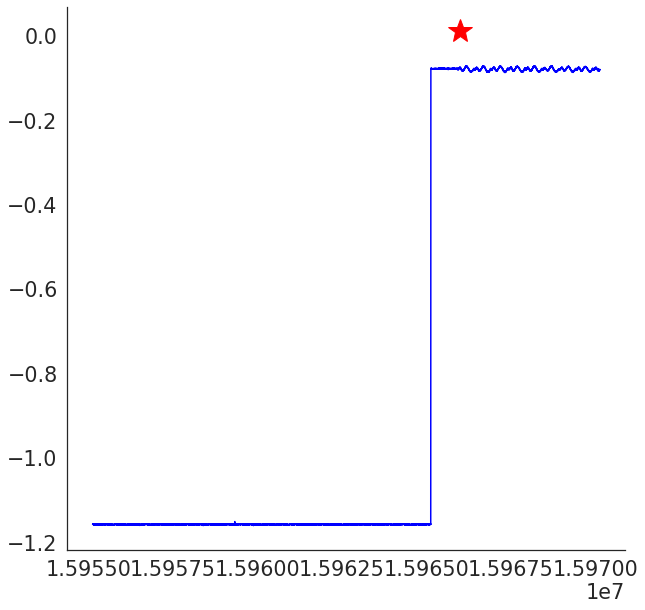

In [126]:
trial_num = 3

plt.figure(figsize=(10,10))

start_fig = square_start[trial_num]-10000
end_fig = square_start[trial_num]+5000

snip_idx = np.arange(start_fig, end_fig)

snip_raster = lambda arr: arr[(arr>start_fig) & (arr<end_fig)]

#plt.plot(snip_idx, diffed[snip_idx] , '--', color='green')

uf.raster_plot(snip_raster(spiral_start), y_pos=0.01, marker='*',
               markersize=25, color='red')
#plt.plot(snip_idx, x_galvo[snip_idx], color='blue')
plt.plot(snip_idx, run.x_galvo_uncaging[snip_idx], color='blue')
#uf.raster_plot(snip_raster(paqio_frames), y_pos=10)
plt.plot()
#plt.ylim(-0.2,0)
#plt.axhline(0.005)

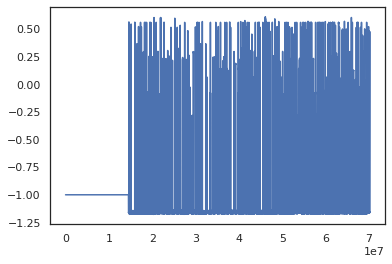

In [17]:
#plt.plot(run.x_galvo_uncaging[int(0.14508e8):int(0.145088e8)])
plt.plot(run.x_galvo_uncaging)


In [153]:
from scipy.signal import butter,filtfilt
# Filter requirements.
fs = 20000      # sample rate, Hz
cutoff = 500  # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic


In [154]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [155]:
filtered = butter_lowpass_filter(run.x_galvo_uncaging, cutoff, fs, order)

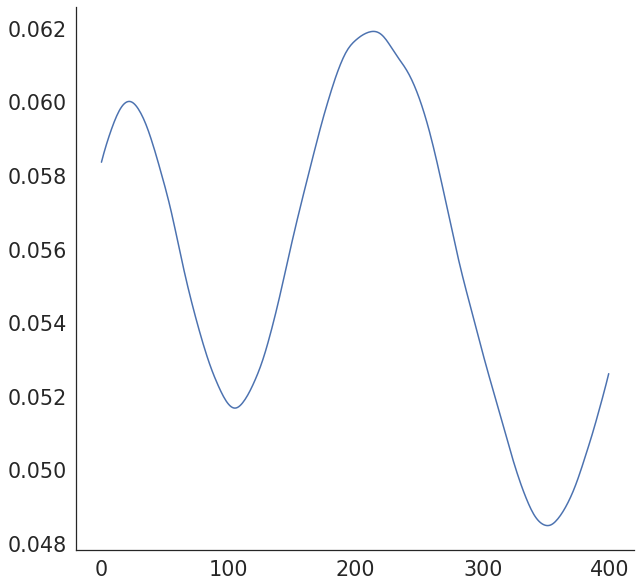

In [160]:
x = run.x_galvo_uncaging
trial_num = 55

plt.figure(figsize=(10,10))

start_fig = square_start[trial_num]-10000
end_fig = square_start[trial_num]+100000

snip_idx = np.arange(start_fig, end_fig)
x = filtered
template = x[int(1.46062e7):int(1.46066e7)]
template = x[int(3.26566e7):int(3.26570e7)]
plt.plot(template)
#plt.xlim((start_fig, end_fig))


In [116]:
import cv2

result = cv2.matchTemplate(
    x.astype(np.float32),
    template.astype(np.float32),
    cv2.TM_SQDIFF)

positions = np.argwhere(result == 0.0)

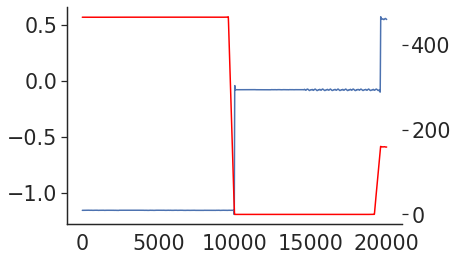

In [117]:


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x[snip_idx])
ax2.plot(result[snip_idx], color='red')


In [18]:
# Test that refactored functions perform the same as notebook functions here
save_path = os.path.join(path_to_vape, 'bad_frames.npy')
trial_starts2, bad_frames = rf.get_bad_frames(run, save_path, fs=30)

PermissionError: [Errno 13] Permission denied: '/bad_frames.npy'

In [ ]:
tester = []

for bad in bad_frames:
    if bad is None:
        tester.append(None)
    else:
        tester.append(bad[pre_frames])

In [ ]:
# Pivot of the bad_frames list from refactored functions should be the
# same as trial starts from here
tester == trial_starts